In this notebook we will compare the MBR scores calculated with the monte-carlo estimates and those from the predictive model
We will try to analyse failure points and think about how to tackle those.



In [1]:
# Some setup code for imports
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from custom_datasets.BayesRiskDatasetLoader import BayesRiskDatasetLoader


In [2]:

# First we will load the test set with the calculated scores.
dataset_loader = BayesRiskDatasetLoader("validation_predictive", n_hypotheses=100, n_references=1000, sampling_method='ancestral')
dataset = dataset_loader.load(type="pandas")

In [3]:
# We will visualize the scores as



In [4]:
import numpy as np
def calculate_mbr_scores(entry):
    scores = []
    count = np.sum(entry["utilities_count"])
    for hyp, util in zip(entry["hypotheses"], entry["utilities"]):
        score = np.sum(util* entry["utilities_count"])/count
        scores.append(score)
    return scores

In [5]:
### Next up we will read the trained model and calculate the score given by the heads
from models.pl_predictive.PLPredictiveModelFactory import PLPredictiveModelFactory
path = "C:/Users/gerso/FBR/predictive/tatoeba-de-en/models/gaussian_mixture_overfitted/"
model, factory = PLPredictiveModelFactory.load(path)
model = model.eval()

C:\Users\gerso\FBR\NMT/tatoeba-de-en/model
0.0
using a mixture model


In [6]:
from models.MBR_model.GaussianMixtureMBRModel import GaussianMixtureMBRModel
wrapped_model = GaussianMixtureMBRModel(model)

In [7]:
import matplotlib.pyplot as plt
def clean(s):
    return s.replace('?', '')

def compare_scores(source, target, hypotheses, monte_carlo_scores, predicted_scores, max_show=15, labels=("Monte Carlo", "predicted"), colors=("b", "r"), save=False):
    
    # First we sort based on scores 1
    #First we show the 
    cleaned_source = clean(source)
    cleaned_target = clean(target)
    
    sorted_indices = np.argsort(-monte_carlo_scores)
    
    monte_carlo_1_sorted = monte_carlo_scores[sorted_indices][:max_show]
    predicted_scores_1_sorted = predicted_scores[sorted_indices][:max_show]
    
    hypotheses_sorted = hypotheses[sorted_indices][:max_show]


    plt.rcdefaults()
    fig, ax = plt.subplots()
        
    
    y_pos = np.arange(len(hypotheses_sorted))
    
    width=0.35

    ax.barh(y_pos - width/2, monte_carlo_1_sorted, width, align='center', color=colors[0], label=labels[0])
    ax.barh(y_pos + width/2, predicted_scores_1_sorted, width, align='center', color=colors[1], label=labels[1])
    
    ax.set_yticks(y_pos, labels=hypotheses_sorted)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('scores')
    ax.set_title('MBR scores sorted on Monte-Carlo: \n {} \n {}'.format(source, target))
    ax.legend()
    
    fig.tight_layout()
    
    if save:
        plt.savefig('{}_{}_{}.png'.format(cleaned_source, cleaned_target, "monte_carlo"), bbox_inches="tight")
    
    plt.show()
   
    
    sorted_indices = np.argsort(-predicted_scores)
    
    monte_carlo_1_sorted = monte_carlo_scores[sorted_indices][:max_show]
    predicted_scores_1_sorted = predicted_scores[sorted_indices][:max_show]
    hypotheses_sorted = hypotheses[sorted_indices][:max_show]
    
    
    plt.rcdefaults()
    fig, ax = plt.subplots()
        
    
    y_pos = np.arange(len(hypotheses_sorted))
    
    width=0.35

    ax.barh(y_pos - width/2, monte_carlo_1_sorted, width, align='center', color=colors[0], label=labels[0])
    ax.barh(y_pos + width/2, predicted_scores_1_sorted, width, align='center', color=colors[1], label=labels[1])
    
    ax.set_yticks(y_pos, labels=hypotheses_sorted)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('scores')
    ax.set_title('MBR scores sorted on predicted: \n {} \n {}'.format(source, target))
    ax.legend()
    fig.tight_layout()
    if save:
        plt.savefig('{}_{}_{}.png'.format(cleaned_source, cleaned_target, "predictive"))
    plt.show()

In [8]:
def compare_random_scores(data, model, n_examples=5, seed=1):
    np.random.seed(seed)
    indices = np.random.choice(len(data), size=n_examples)
    
    for i in indices:
        entry = data.iloc[i]
        source = entry["source"]
        hypotheses = np.array(entry["hypotheses"])
        
        predicted_scores = model.get_scores([source] * len(hypotheses), list(hypotheses)).cpu().numpy().flatten()
        print(predicted_scores)
        monte_carlo_scores =  np.array(calculate_mbr_scores(entry))
        compare_scores(source, entry["target"], hypotheses,  monte_carlo_scores, predicted_scores, labels=["Monte carlo", 'predicted'], save=True)
    
    

C:\Users\gerso\projects\master-thesis\models\MBR_model\GaussianMixtureMBRModel.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  result = {k: torch.tensor(v) for k, v in result.items()}


[1.092885   0.84149975]


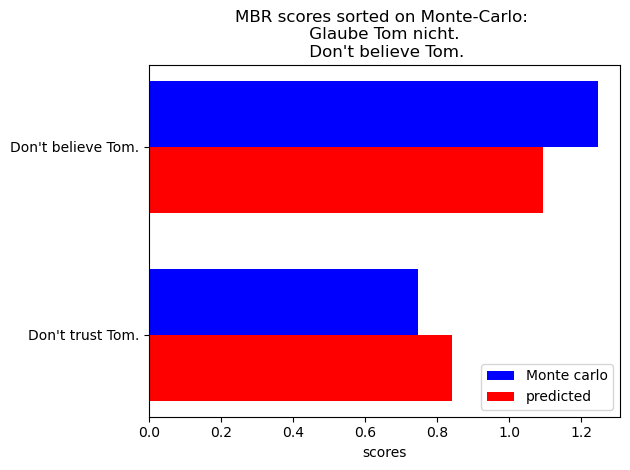

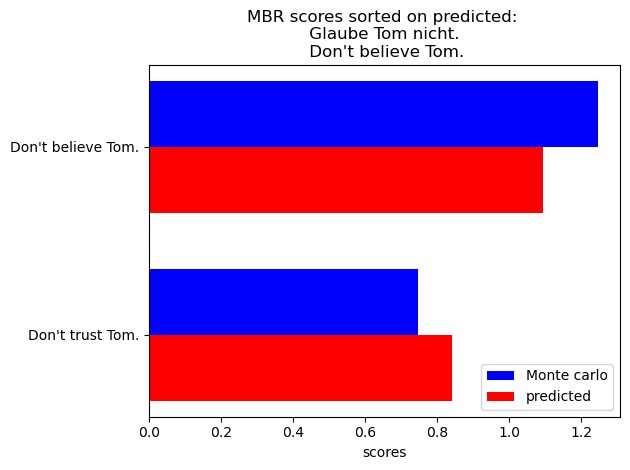

[0.8096843  0.83986306 0.65730584 0.78594327]


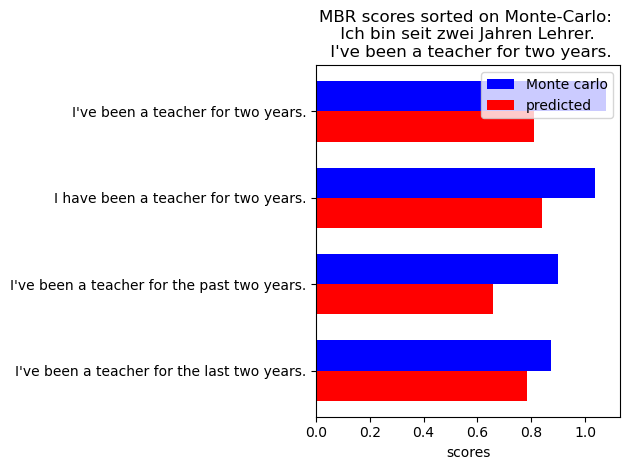

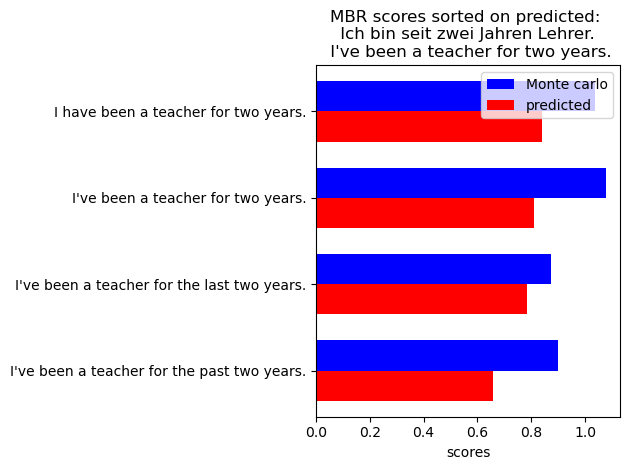

[0.68964905 0.6686834  0.47099817]


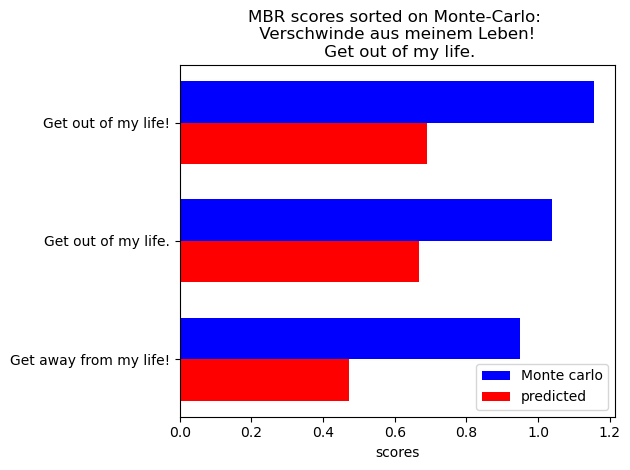

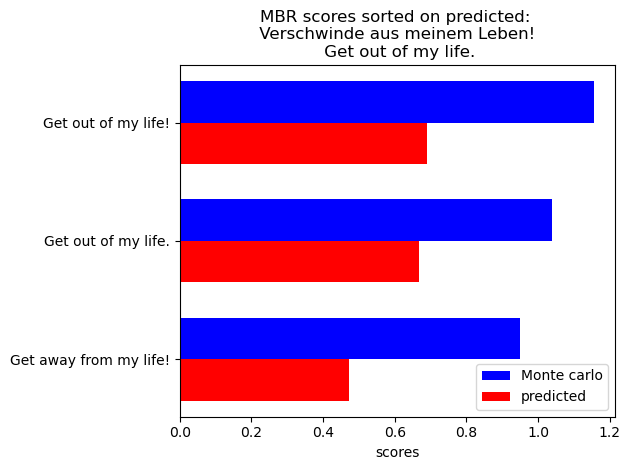

[0.6903191 0.5943332 0.5167297]


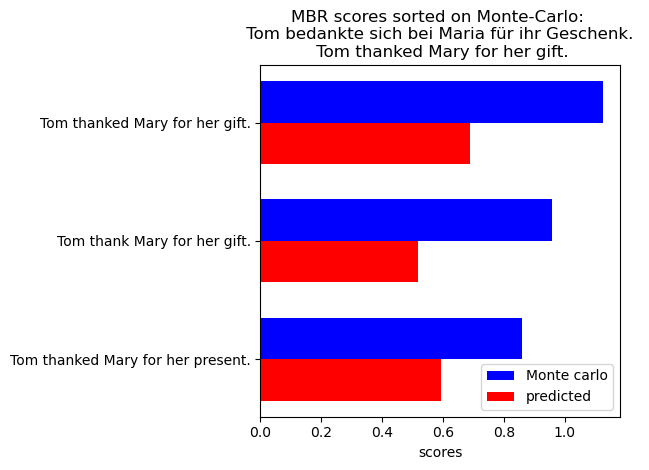

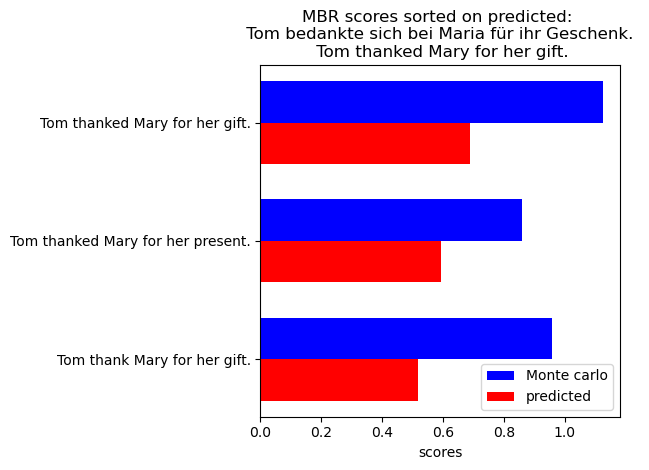

[ 0.6808334   0.62481093  0.6428266   0.68481725  0.2857901  -0.14979431]


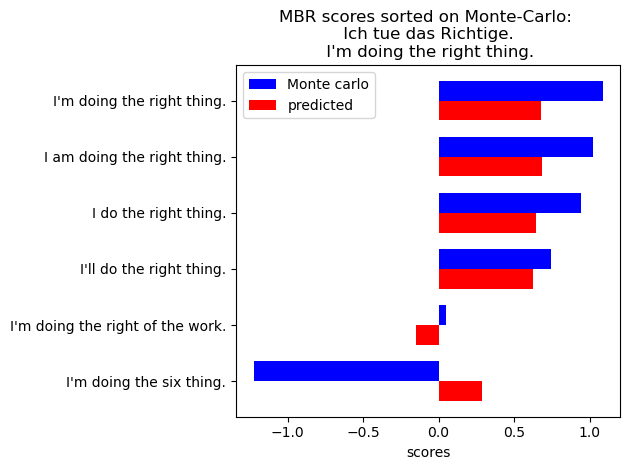

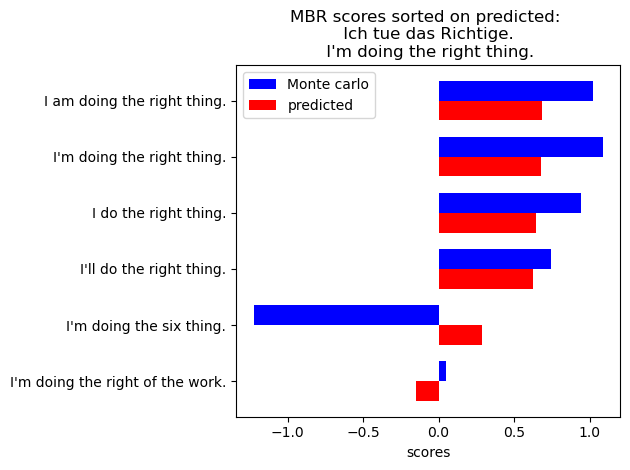

In [9]:
compare_random_scores(dataset.data, wrapped_model)

In [10]:
def get_repeated_utils(utilities, count):
    
    repeated_utils = []
    for util in utilities:
        
        r = []
        for u, c in zip(util, count):
            r += [u] * c
        repeated_utils.append(r)
    return repeated_utils
    
    

In [11]:

import torch.distributions as td
import torch

colors = ["red", 'orange', 'purple', 'c' ]
def show_gaussian_mix(loc, scale, weights, data, source, target, hypothesis, predicted_mean, save=False, path='./imgs/'):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
   
    
    
    cleaned_source = clean(source)
    cleaned_target = clean(target)
    cleaned_hypothesis = clean(hypothesis)
    
    # First plot the histogram
    #ax.hist(data, 250, density=False, facecolor='g', alpha=0.75, label="scores",)
    ax.scatter(data, [1]*len(data))
    # Next up we plot the gaussian we tried to fit

    dists = []
    
    for i, (l, s,w) in enumerate(zip(loc, scale, weights)):
        
        dist = td.Normal(l, s)
    
        color = colors[i]
        x = torch.Tensor(np.linspace(l - 2* s, l + 2 * s, 100))
        probs = np.exp(dist.log_prob(x))
        ax.plot(x, probs, label="Predicted fit:\nweight: {}, \nLoc: {}, Scale: {}".format(str(round(w, 2)), str(round(l, 2)), str(round(s, 2))), color=color) 
    
      
    middle_point = int(len(probs)/2)
    avg = np.mean(data)
    ax.scatter(avg, probs[middle_point] + 10, color="g", label="mean: {}".format(str(round(avg, 2))), marker="o")
    
    ax.scatter(predicted_mean, probs[middle_point] + 10, label="predicted mean: {}".format(str(round(predicted_mean, 2))), marker="x",  color='red')
    
    ax.set_xlabel('scores')
    ax.set_title('MBR scores histogram with Gaussian: \n {} \n {}'.format(source, hypothesis))
    ax.legend()
    fig.tight_layout()
    if save:
        plt.savefig('{}fitted_gaussian_{}_{}.png'.format(path, cleaned_source, cleaned_hypothesis))
    
    plt.show()



{'loc': tensor([[1.1731, 0.8059]]), 'scale': tensor([[0.1381, 0.2431]]), 'logits': tensor([[ 0.7513, -0.6377]])}


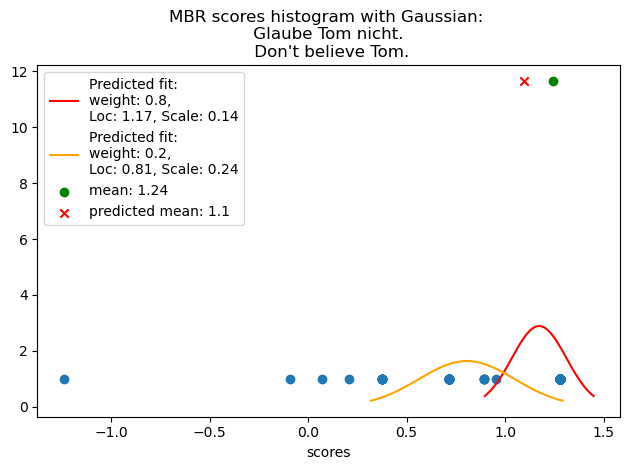

{'loc': tensor([[1.0532, 0.1113]]), 'scale': tensor([[0.1962, 0.3694]]), 'logits': tensor([[ 0.7680, -0.6307]])}


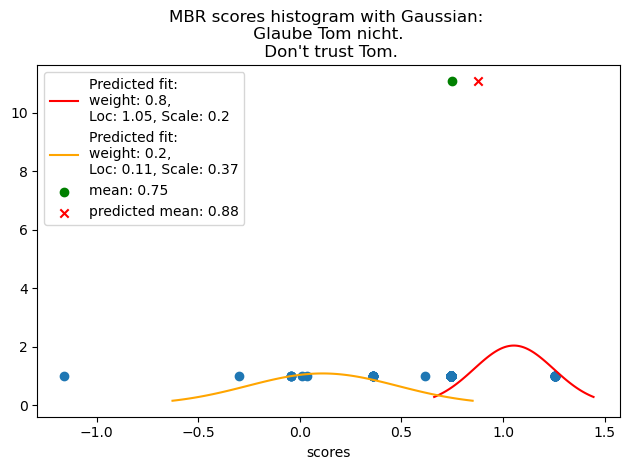

{'loc': tensor([[1.1731, 0.8059]]), 'scale': tensor([[0.1381, 0.2431]]), 'logits': tensor([[ 0.7513, -0.6377]])}


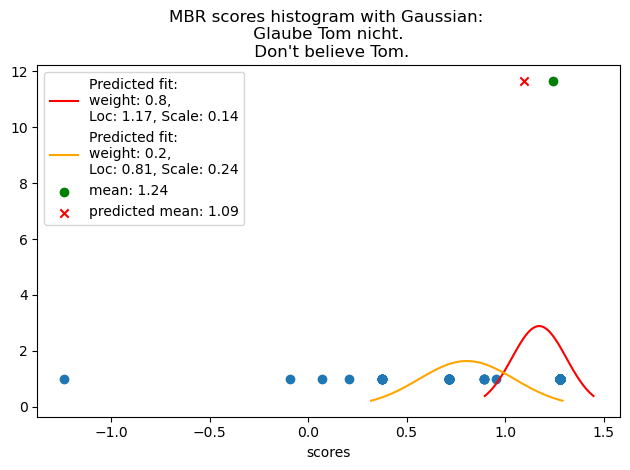

{'loc': tensor([[1.0532, 0.1113]]), 'scale': tensor([[0.1962, 0.3694]]), 'logits': tensor([[ 0.7680, -0.6307]])}


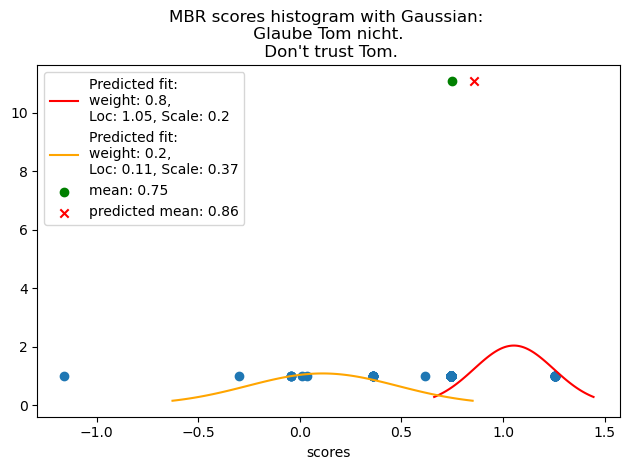

{'loc': tensor([[0.9472, 0.3496]]), 'scale': tensor([[0.1356, 0.2173]]), 'logits': tensor([[ 0.8303, -0.6145]])}


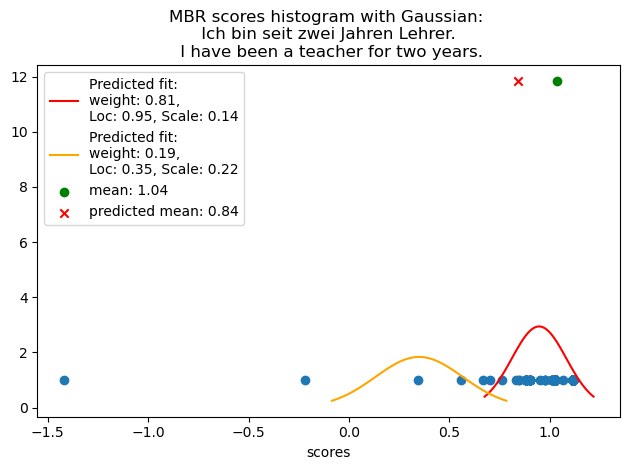

{'loc': tensor([[0.9356, 0.2884]]), 'scale': tensor([[0.1434, 0.2498]]), 'logits': tensor([[ 0.8350, -0.6318]])}


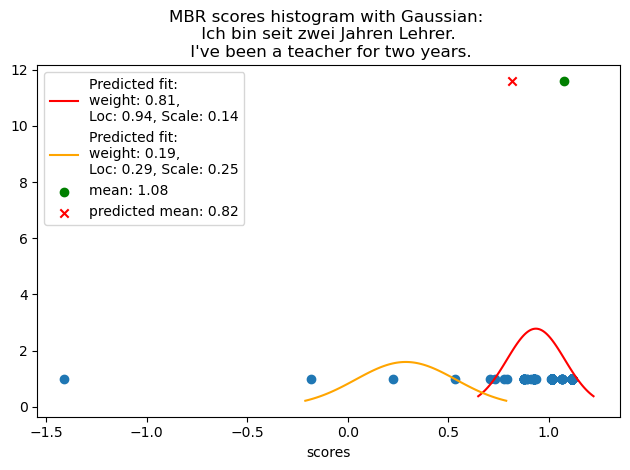

{'loc': tensor([[0.8319, 0.0260]]), 'scale': tensor([[0.1602, 0.2333]]), 'logits': tensor([[ 0.7217, -0.4917]])}


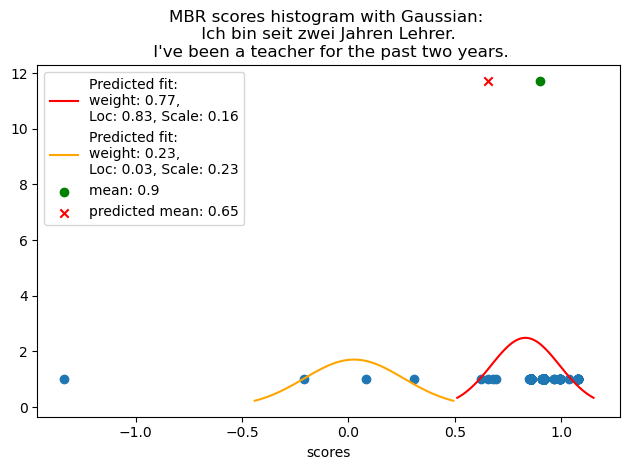

{'loc': tensor([[0.9472, 0.3496]]), 'scale': tensor([[0.1356, 0.2173]]), 'logits': tensor([[ 0.8303, -0.6145]])}


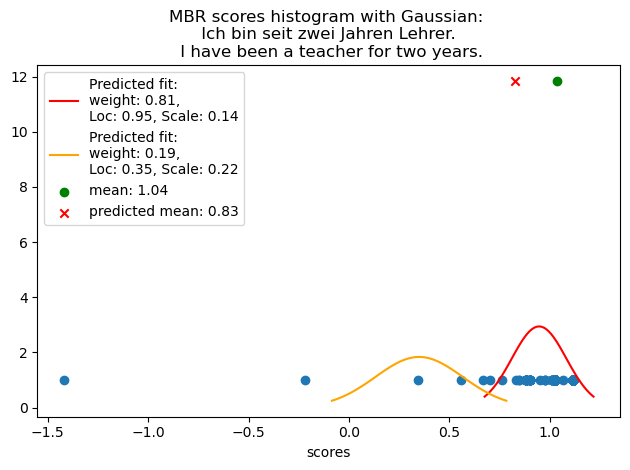

{'loc': tensor([[0.6192, 0.1718]]), 'scale': tensor([[0.4878, 0.5707]]), 'logits': tensor([[ 0.4310, -0.3416]])}


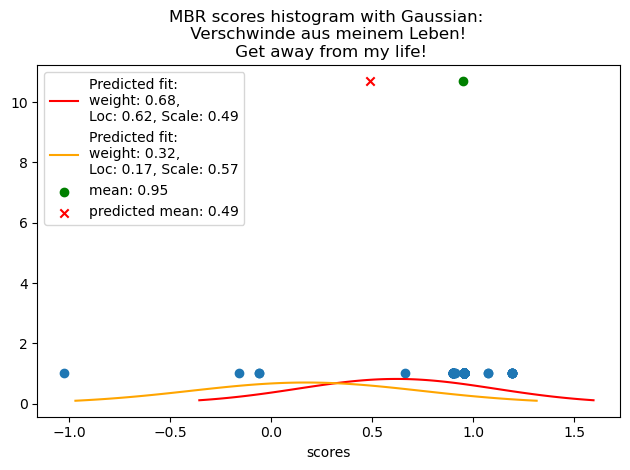

{'loc': tensor([[0.7892, 0.3647]]), 'scale': tensor([[0.3589, 0.4436]]), 'logits': tensor([[ 0.5245, -0.4567]])}


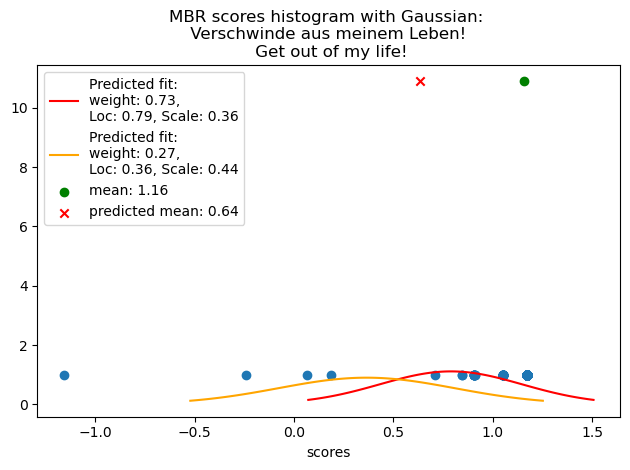

{'loc': tensor([[0.6192, 0.1718]]), 'scale': tensor([[0.4878, 0.5707]]), 'logits': tensor([[ 0.4310, -0.3416]])}


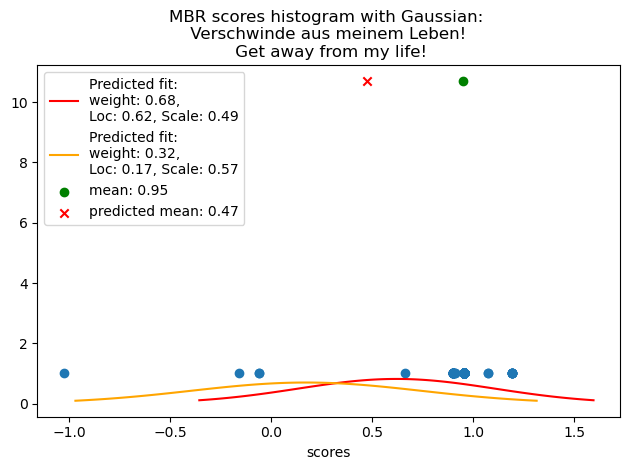

{'loc': tensor([[0.7875, 0.3609]]), 'scale': tensor([[0.3606, 0.4445]]), 'logits': tensor([[ 0.5230, -0.4552]])}


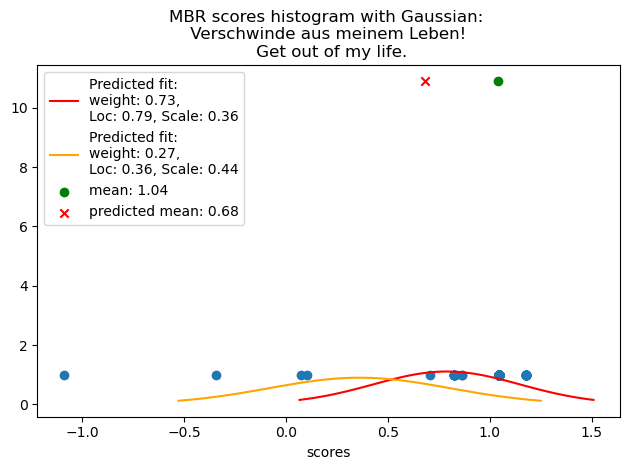

{'loc': tensor([[ 0.7993, -0.2020]]), 'scale': tensor([[0.3824, 0.4865]]), 'logits': tensor([[ 0.6033, -0.4692]])}


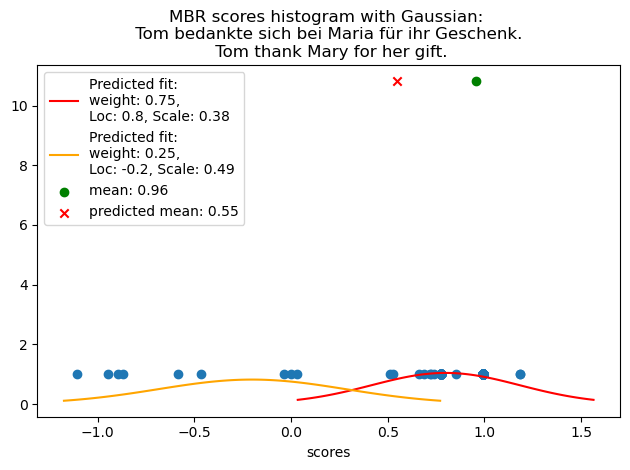

{'loc': tensor([[0.8690, 0.1419]]), 'scale': tensor([[0.3544, 0.5043]]), 'logits': tensor([[ 0.5866, -0.4714]])}


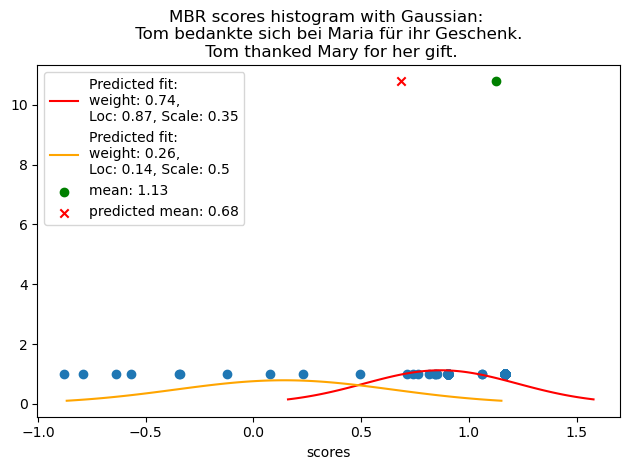

{'loc': tensor([[0.8690, 0.1419]]), 'scale': tensor([[0.3544, 0.5043]]), 'logits': tensor([[ 0.5866, -0.4714]])}


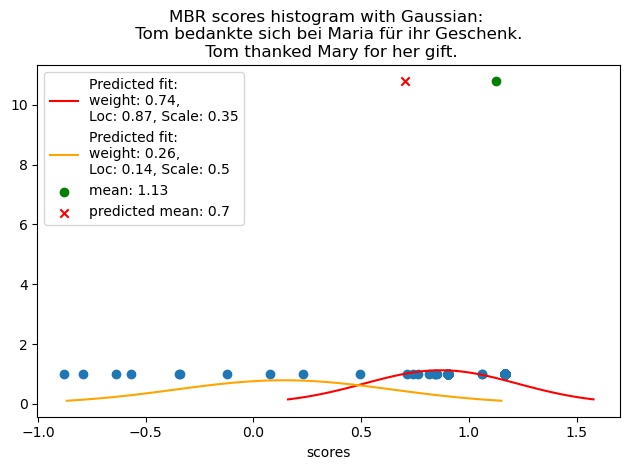

{'loc': tensor([[ 0.7993, -0.2020]]), 'scale': tensor([[0.3824, 0.4865]]), 'logits': tensor([[ 0.6033, -0.4692]])}


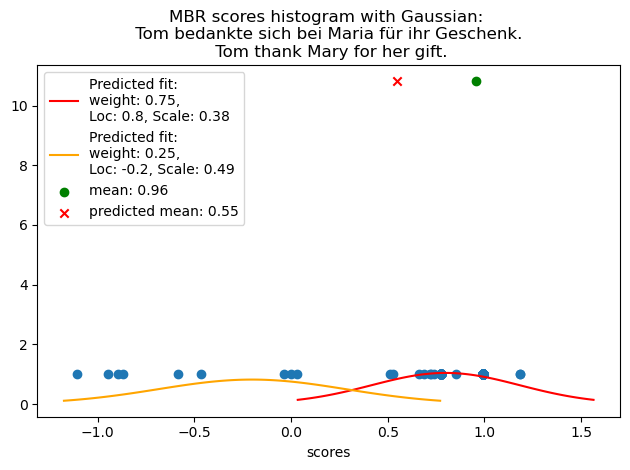

{'loc': tensor([[ 0.5877, -0.6402]]), 'scale': tensor([[0.3653, 0.3265]]), 'logits': tensor([[ 0.5693, -0.3927]])}


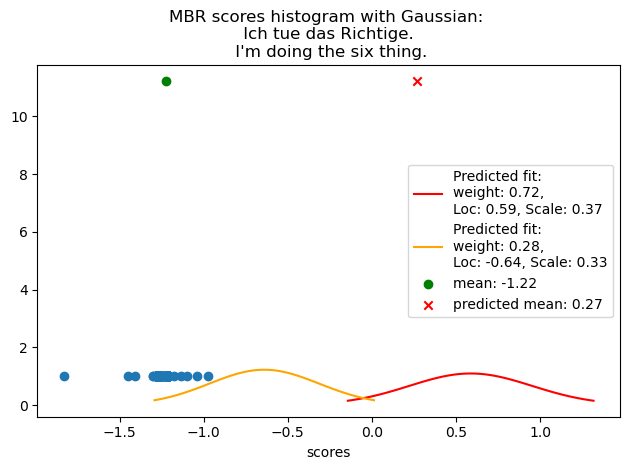

{'loc': tensor([[ 0.2740, -0.7974]]), 'scale': tensor([[0.3925, 0.2337]]), 'logits': tensor([[ 0.3625, -0.1388]])}


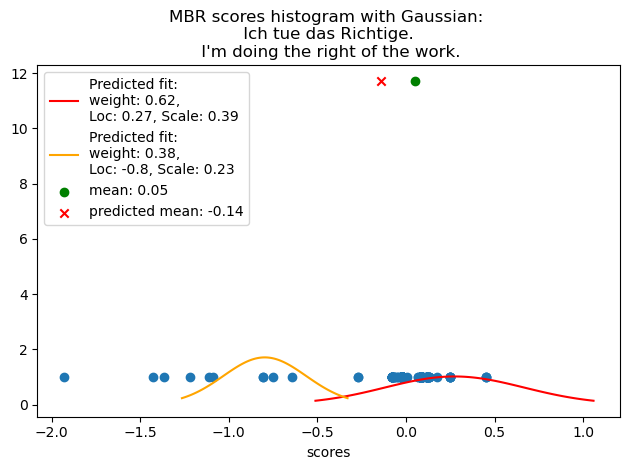

{'loc': tensor([[0.8301, 0.0191]]), 'scale': tensor([[0.2676, 0.3082]]), 'logits': tensor([[ 0.6562, -0.5447]])}


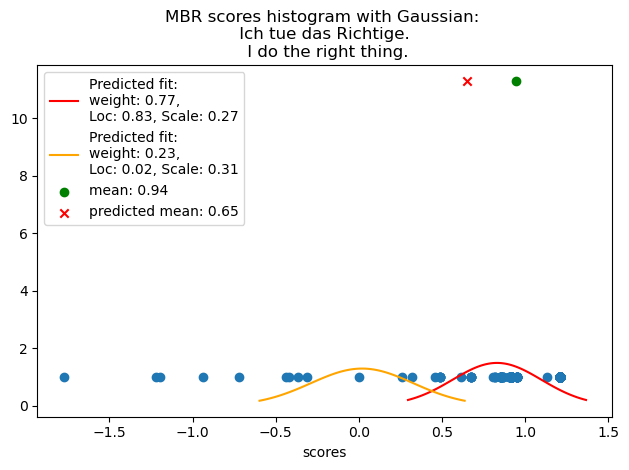

{'loc': tensor([[ 0.5877, -0.6402]]), 'scale': tensor([[0.3653, 0.3265]]), 'logits': tensor([[ 0.5693, -0.3927]])}


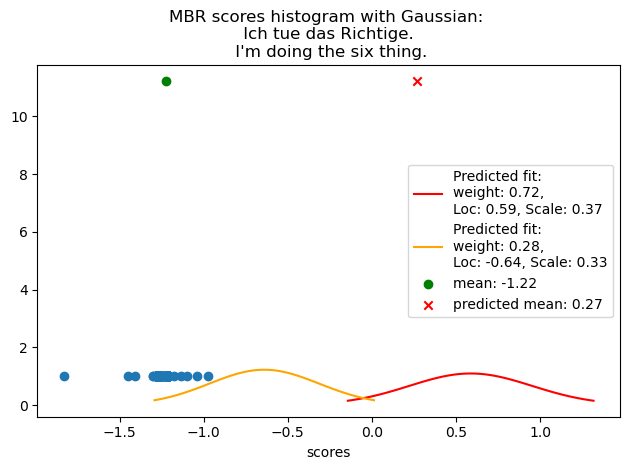

In [12]:
def compare_data_with_model(data, model, n_sources=5, n_hypotheses=4, seed=1, path='./test_imgs/'):
    np.random.seed(seed)
    indices = np.random.choice(len(data), size=n_sources)
    
    
    for i in indices:
        entry = data.iloc[i]
        repeated_utils = get_repeated_utils(entry["utilities"], entry["utilities_count"])
        hypotheses_indices = np.random.choice(len(entry["utilities"]), size=n_hypotheses)
        for hypothesis_index in hypotheses_indices:
            hypothesis = entry["hypotheses"][hypothesis_index]
            target = entry["target"]
            source = entry["source"]

            utils = repeated_utils[hypothesis_index]
            
            model_out = model.get_model_out([source], [hypothesis])
            print(model_out)
            predicted_mean = wrapped_model.model_out_to_mean(model_out).cpu().item()
            
            
            
            loc = model_out["loc"][0].cpu().numpy()
            scale = model_out["scale"][0].cpu().numpy()
            
           
            weights = torch.softmax(model_out['logits'][0], dim=-1).cpu().numpy()
            show_gaussian_mix(loc, scale, weights, utils, source, target, hypothesis,  predicted_mean, save=True, path=path)

compare_data_with_model(dataset.data, wrapped_model, )      


In [13]:
#train dataset
dataset_loader = BayesRiskDatasetLoader("train_predictive", n_hypotheses=100, n_references=1000, sampling_method='ancestral')
dataset_train = dataset_loader.load(type="pandas")

{'loc': tensor([[0.9693, 0.7112]]), 'scale': tensor([[0.1152, 0.1389]]), 'logits': tensor([[ 0.7301, -0.5154]])}


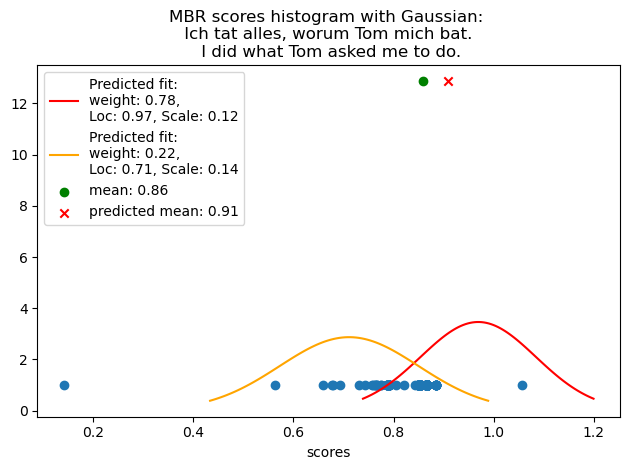

{'loc': tensor([[0.9615, 0.7210]]), 'scale': tensor([[0.0935, 0.1092]]), 'logits': tensor([[ 0.7940, -0.5656]])}


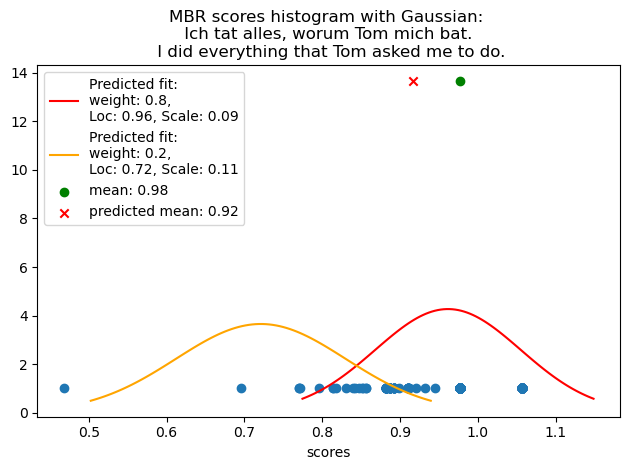

{'loc': tensor([[0.9615, 0.7210]]), 'scale': tensor([[0.0935, 0.1092]]), 'logits': tensor([[ 0.7940, -0.5656]])}


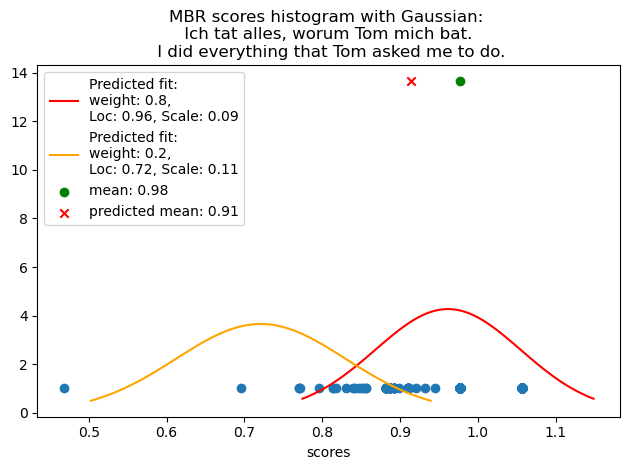

{'loc': tensor([[0.9298, 0.6432]]), 'scale': tensor([[0.1071, 0.1313]]), 'logits': tensor([[ 0.7682, -0.5492]])}


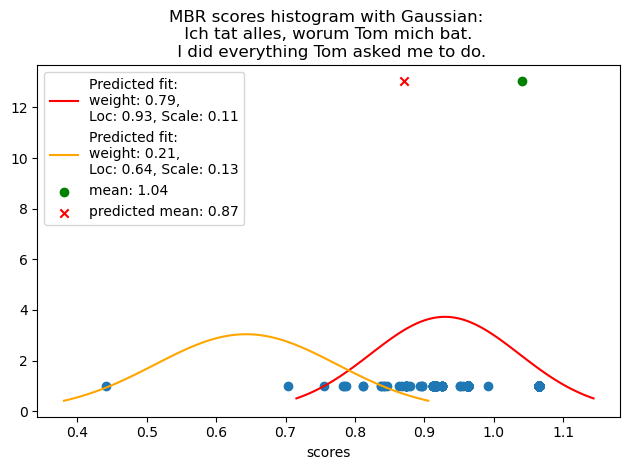

{'loc': tensor([[ 0.3647, -0.4652]]), 'scale': tensor([[0.3014, 0.2663]]), 'logits': tensor([[ 0.2890, -0.1145]])}


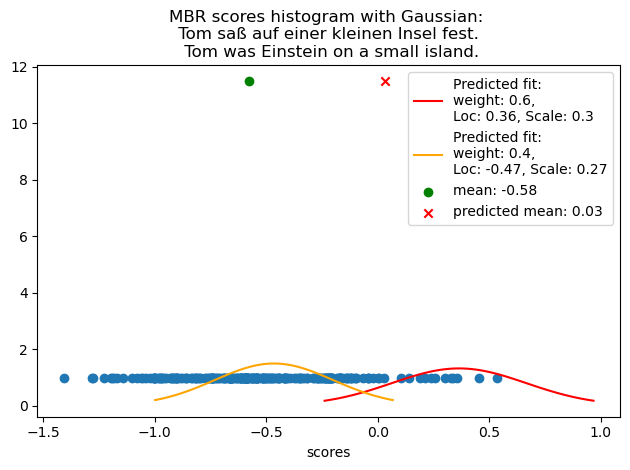

{'loc': tensor([[ 0.3197, -0.4263]]), 'scale': tensor([[0.2849, 0.2566]]), 'logits': tensor([[ 0.2697, -0.0905]])}


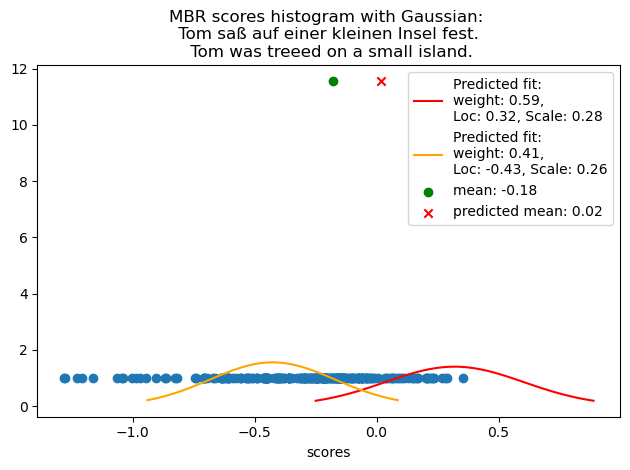

{'loc': tensor([[-0.2641, -0.8945]]), 'scale': tensor([[0.2956, 0.2007]]), 'logits': tensor([[0.1264, 0.0447]])}


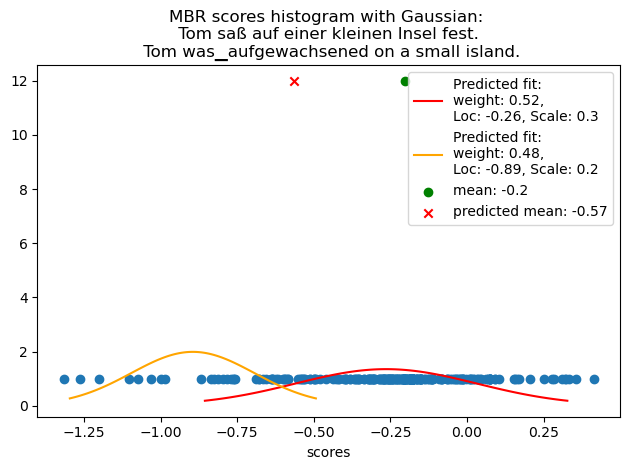

{'loc': tensor([[ 0.3647, -0.4652]]), 'scale': tensor([[0.3014, 0.2663]]), 'logits': tensor([[ 0.2890, -0.1145]])}


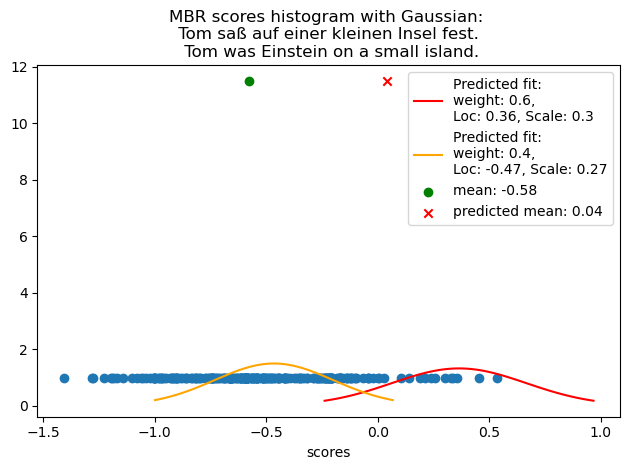

{'loc': tensor([[-0.4238, -0.8899]]), 'scale': tensor([[0.4028, 0.2518]]), 'logits': tensor([[ 0.2027, -0.0295]])}


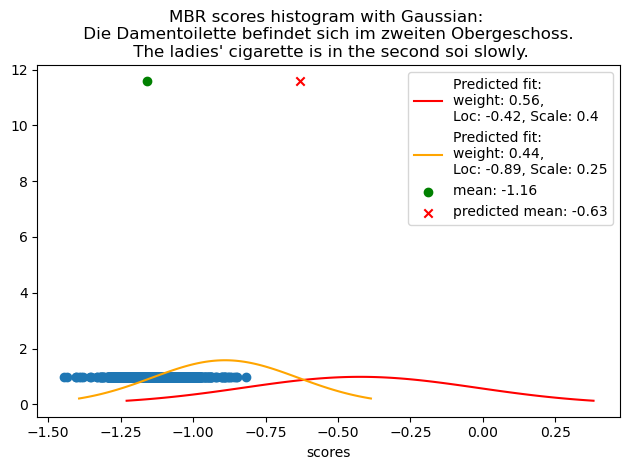

{'loc': tensor([[-0.5395, -0.9687]]), 'scale': tensor([[0.4121, 0.2464]]), 'logits': tensor([[ 0.2204, -0.0524]])}


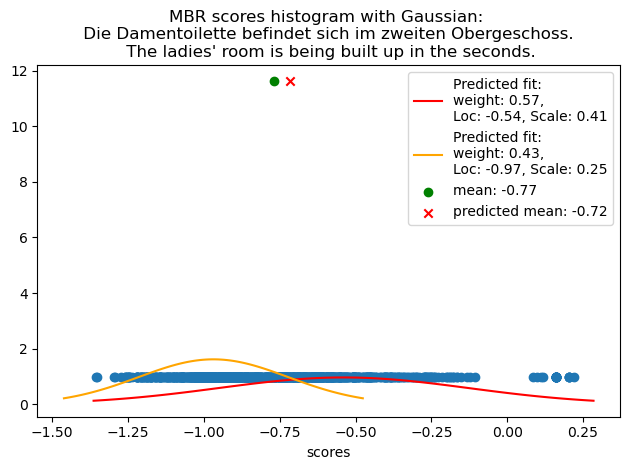

{'loc': tensor([[-0.7766, -1.1591]]), 'scale': tensor([[0.3062, 0.1442]]), 'logits': tensor([[0.0716, 0.0915]])}


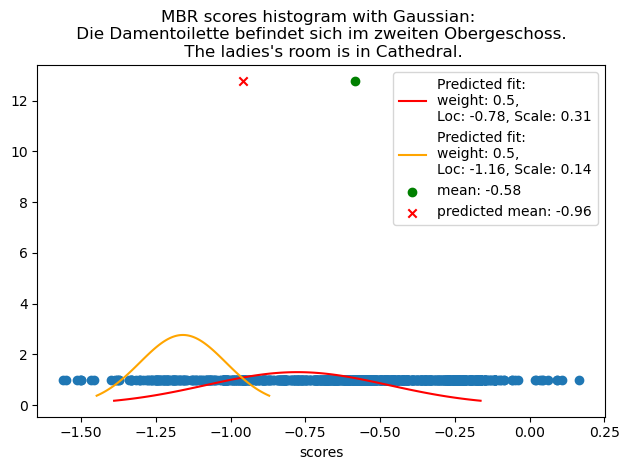

{'loc': tensor([[-0.0894, -0.6169]]), 'scale': tensor([[0.5499, 0.3844]]), 'logits': tensor([[ 0.2870, -0.1340]])}


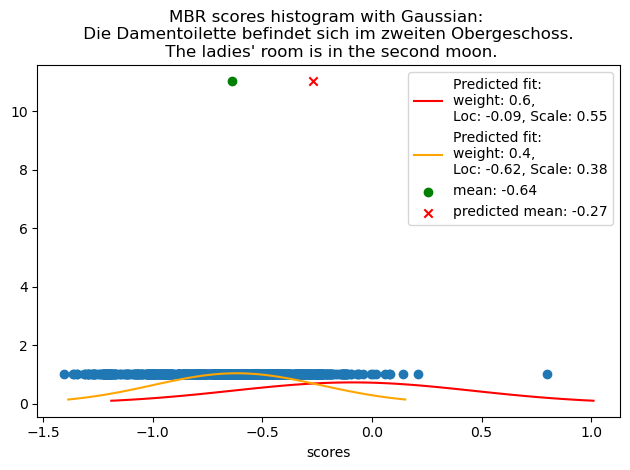

{'loc': tensor([[ 0.1008, -0.8565]]), 'scale': tensor([[0.2503, 0.2015]]), 'logits': tensor([[ 0.3049, -0.0796]])}


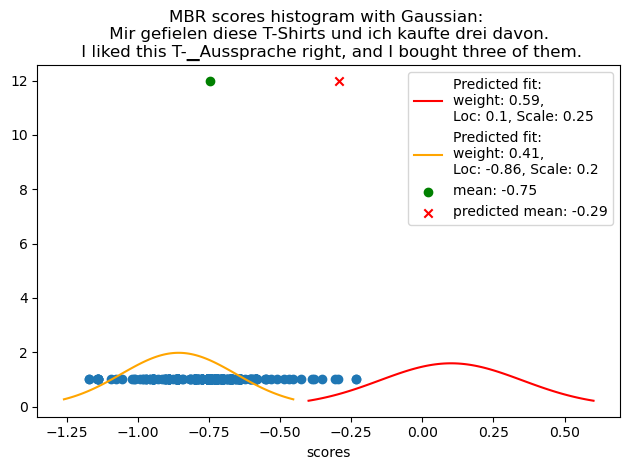

{'loc': tensor([[0.9509, 0.3387]]), 'scale': tensor([[0.1526, 0.2154]]), 'logits': tensor([[ 0.8008, -0.5537]])}


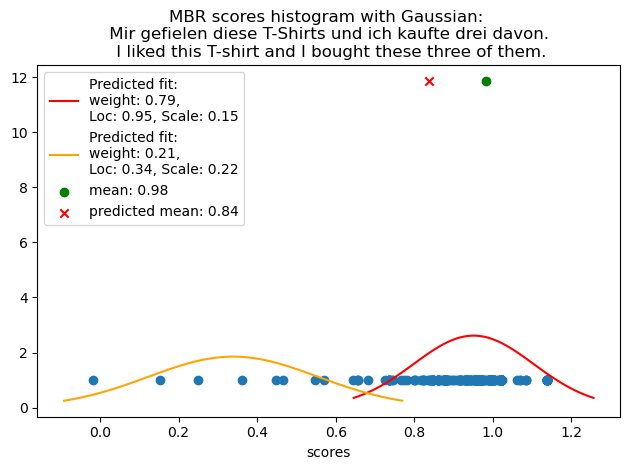

{'loc': tensor([[1.0330, 0.4937]]), 'scale': tensor([[0.1392, 0.2112]]), 'logits': tensor([[ 0.8426, -0.6169]])}


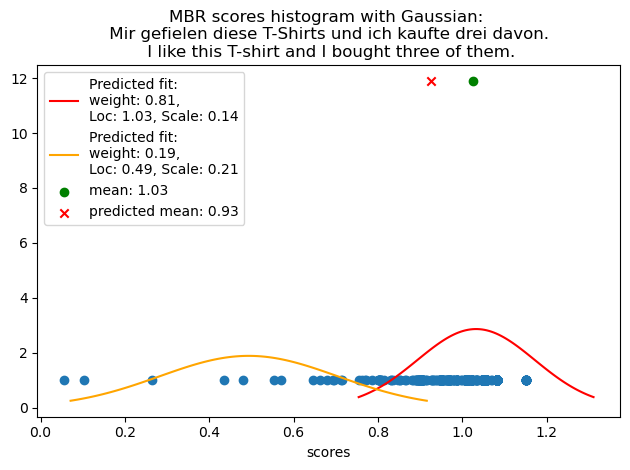

{'loc': tensor([[ 0.8728, -0.1773]]), 'scale': tensor([[0.1814, 0.2800]]), 'logits': tensor([[ 0.8559, -0.5859]])}


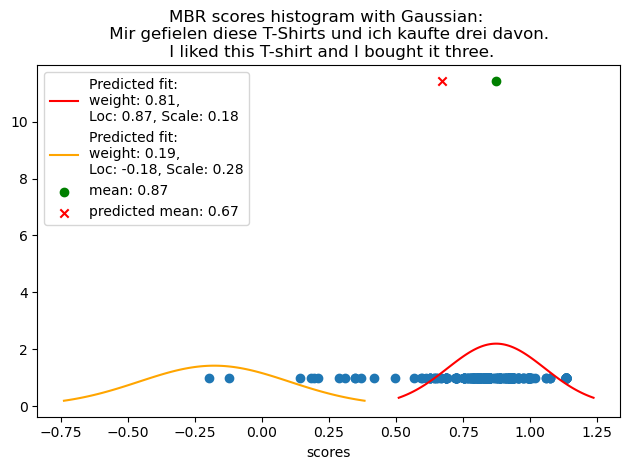

{'loc': tensor([[-1.1553, -1.2931]]), 'scale': tensor([[0.1247, 0.0954]]), 'logits': tensor([[0.0367, 0.1154]])}


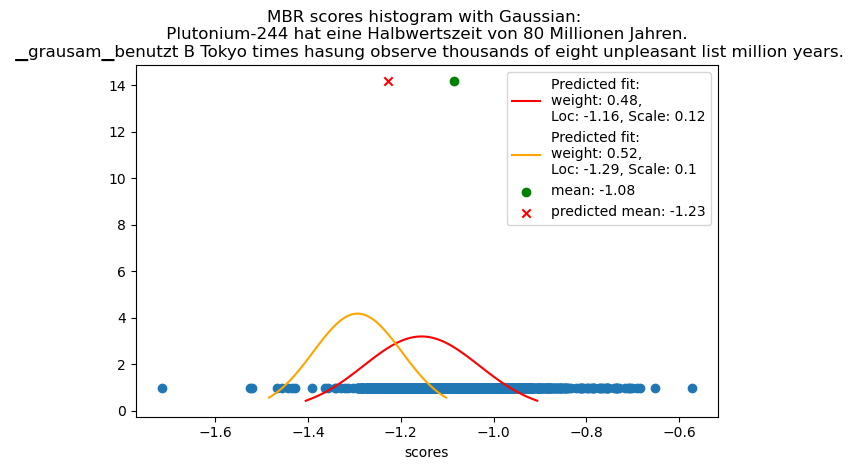

{'loc': tensor([[-0.9237, -1.1102]]), 'scale': tensor([[0.2763, 0.1562]]), 'logits': tensor([[0.0748, 0.0883]])}


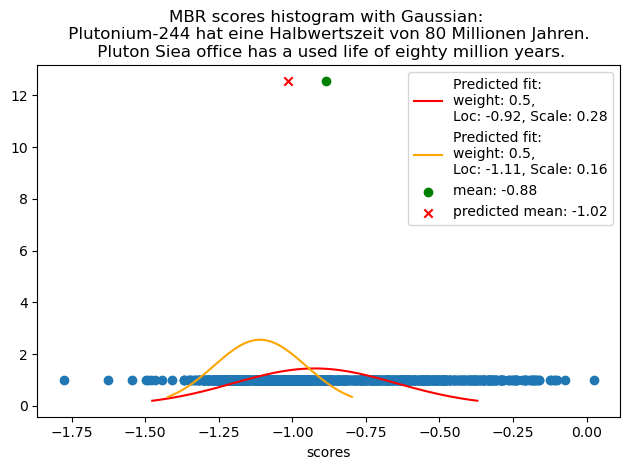

{'loc': tensor([[-1.0137, -1.1533]]), 'scale': tensor([[0.1963, 0.1218]]), 'logits': tensor([[0.0478, 0.1230]])}


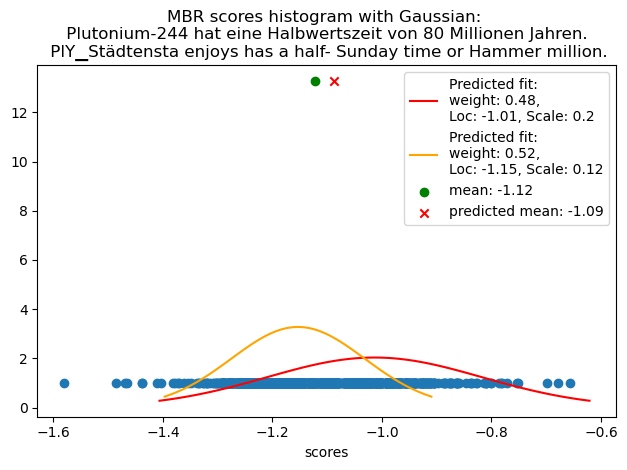

{'loc': tensor([[-1.1042, -1.2315]]), 'scale': tensor([[0.1479, 0.1000]]), 'logits': tensor([[0.0294, 0.1248]])}


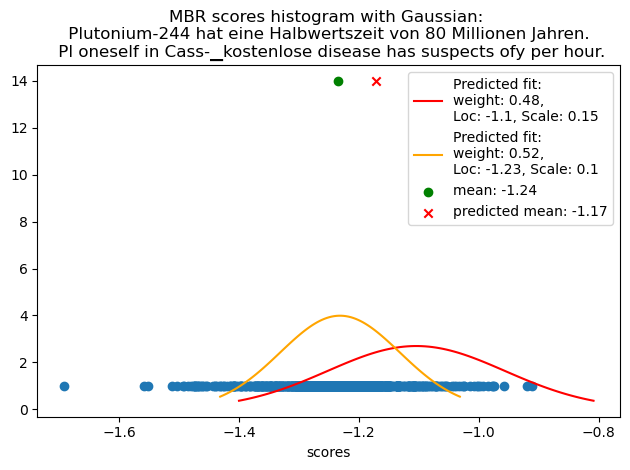

In [14]:


compare_data_with_model(dataset_train.data, wrapped_model, path="./train_imgs/")    